In [17]:
import numpy as np
import matplotlib.pyplot as plt
import random
from enum import Enum, auto
import math
import matplotlib.animation as anim
import sys
from IPython.display import clear_output
from IPython import display

In [18]:
ħ = 1#1.34**-34
e = 1.6 ** -19

In [19]:
class ParticleState(Enum):
    NOTHING = auto()
    DEAD = auto()
    NEW = auto()


def get_pactilce_state(E, U, dt):
    res = 1 / ħ * (E - U) * dt
    bone = random.random()
    if bone > abs(res):
        return ParticleState.NOTHING
    if res < 0:
        return ParticleState.DEAD
    else:
        return ParticleState.NEW

In [20]:
__left = np.array([-1], np.uint32)
__right = np.array([1], np.uint32)
__zeros = np.array([0], np.uint32)

def next_step_2D(q):
    bone = random.random()
    if bone < q:
        return __left
    elif bone > 1 - q:
        return __right
    else:
        return __zeros

In [21]:
class Position2D:
    __slots__ = ['pos']

    def __init__(self, pos):
        assert pos.dtype == np.int32
        self.pos = pos


class Grid2D:
    def __init__(self, x_min, x_max, nx, U_func):
        self.nx = nx

        x = np.linspace(x_min, x_max, nx)

        self.grid = np.empty(nx)
        for i in range(nx):
            self.grid[i] = U_func(x[i])

    def get_random_place(self):
        return np.array([random.randrange(0, self.grid.shape[0])], np.int32)

    def is_contain(self, pos):
        return (0 <= pos[0] and pos[0] < self.nx)

    def __getitem__(self, item):
        return self.grid.__getitem__(item)


class StepResult(Enum):
    BORN = auto(),
    DEAD = auto(),
    DISPLACEMENT = auto()
    FOUND = auto()

In [78]:
class SolverMonteCarlo:
    def __init__(self, dt, q, grid, E_min, E_max, E_precision):
        self.dt = dt
        self.q = q
        self.grid = grid
        self.particles = []
        self.idx_cur_pacticle = None

        assert E_max > E_min
        self.E_half = (E_max - E_min) / 2
        self.E = E_min
        self.E_precision = E_precision

        self._calibration_particles_count = 0
        self._calibration_percent = 0.05
        self._enough_cycle_length = 0
        self._steps_in_cycle = 0

        self.steps = 0
        self.E_arr = []

    def print_stats(self):
        self.E_arr.append(self.E)
        return False
#         print(f"step {self.steps}")
#         print(f"E {self.E} +- {self.E_half}")
#         print(f"particles {len(self.particles)}")
#         clear_output()

    def __up_E(self):
        self.E += self.E_half
        self.E_half /= 2

#         print("up")
        self.print_stats()


    def __down_E(self):
        self.E -= self.E_half
        self.E_half /= 2

#         print("down")
        self.print_stats()

    # 1 is cur_particle more, 0 is fit
    def __is_count_particle_fit(self):
        if abs(self._calibration_particles_count - len(self.particles)) <\
                len(self.particles) * self._calibration_percent:
            return 0
        else:
            if len(self.particles) > self._calibration_particles_count:
                return 1
            else:
                return -1

    def __update_calibration_param(self):
        self._calibration_particles_count = len(self.particles)
        self._enough_cycle_length = self._calibration_particles_count * self._calibration_percent * 20
        self._steps_in_cycle = 0

    def born_particles(self, n=10_000):
        self.particles = []
        self.idx_cur_pacticle = None

        count = 0
        tries = 0
        # inf loop maybe
        while count < n:
            pos = self.grid.get_random_place()

            if self.E - self.grid[pos[0]] > 0:
                self.particles.append(Position2D(pos))
                count += 1
                tries = 0
            else:
                tries += 1
                if tries > 100:
                    self.__up_E()
                    tries = 0

        self.__update_calibration_param()

    def __delete_particle(self, idx):
        if idx + 1 == len(self.particles):
            self.particles.pop()
        else:
            self.particles[idx] = self.particles.pop()

    def step(self):
        self.steps += 1

        self._steps_in_cycle += 1
        if self._steps_in_cycle > self._enough_cycle_length:
            if random.randrange(2):
                self.__up_E()
            else:
                self.__down_E()

            self.born_particles()

        if self.E_half < self.E_precision:
            return StepResult.FOUND, self.E

        count_particle_enough_to_continue = self.__is_count_particle_fit()
        if count_particle_enough_to_continue != 0:
            if count_particle_enough_to_continue == 1:
                self.__down_E()
            else:
                self.__up_E()

            self.born_particles()

        if self.idx_cur_pacticle is None:
            if not self.particles:
                print("no more particles, born them")
                self.born_particles()

            self.idx_cur_pacticle = random.randrange(len(self.particles))

        pos = self.particles[self.idx_cur_pacticle].pos
        backup_pos = pos.copy()
        assert self.grid.is_contain(backup_pos)

        pos += next_step_2D(self.q)
        if not self.grid.is_contain(pos):
            self.__delete_particle(self.idx_cur_pacticle)
            self.idx_cur_pacticle = None
            return StepResult.DEAD, backup_pos

        ret_state = StepResult.DISPLACEMENT

        state = get_pactilce_state(self.E, self.grid[pos[0]], self.dt)
        if state is ParticleState.NEW:
            self.particles.append(Position2D(pos.copy()))
            ret_state = StepResult.BORN
        elif state is ParticleState.DEAD:
            self.__delete_particle(self.idx_cur_pacticle)
            self.idx_cur_pacticle = None
            ret_state = StepResult.DEAD

        return ret_state, backup_pos



In [96]:
N = 500
size = 6
dt = 0.1
q = 0.24

border = 8


def U_func(r):
    temp = r ** 2
    if abs(r) >= border:
        return float('inf')
    return temp

grid = Grid2D(-size, size, N, U_func)

mc = SolverMonteCarlo(dt, q, grid, -1e6, 1e6, 1e-15)
mc.born_particles(10_000)

In [97]:
def gen_data():
    img = np.zeros((mc.grid.grid.shape[0]), np.uint32)

    for i in range(1000):
        for _ in range(10000):
            event, pos = mc.step()
            if event is StepResult.FOUND:
                print(f"found {mc.E}")
                return

            x = pos[0]
            if event is StepResult.DISPLACEMENT:
                img[x] += 1
            elif event is StepResult.BORN:
                img[x] += 1
            elif event is StepResult.DEAD:
                pass

        yield img

In [98]:
def plot_animated(it):
    it = iter(it)

    i=0
    while True:
        i = i + 1
#         if i % 50 != 0:
#             continue

            
        u = mc.grid.grid.copy()
        try:
            img = next(it)
        except StopIteration:
            break
        pass
    
        if i % 2 != 0:
            continue
            
        aaaa = np.max(img) / np.max(abs(u[u < 10000]))
        u = u * np.max(img) / np.max(abs(u[u < 10000]))

        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.clf()
        
#         plt.figure(figsize = (10,10))
        plt.plot(np.linspace(-size, size, N), img, color='green', label='ψ') #  {:f}'.format(np.max(img))
        plt.plot([-size, size], [mc.E * aaaa, mc.E * aaaa], color='red',label='E_level' ) #  {:f}'.format(aaaa)
        plt.plot(np.linspace(-size, size, N), u)
        plt.legend(loc="upper right")
        plt.title(i)
        plt.draw()
        
#         break
#         plt.pause(0.0001)   

    print("anim ended")  




found 0.7190979553069986
anim ended


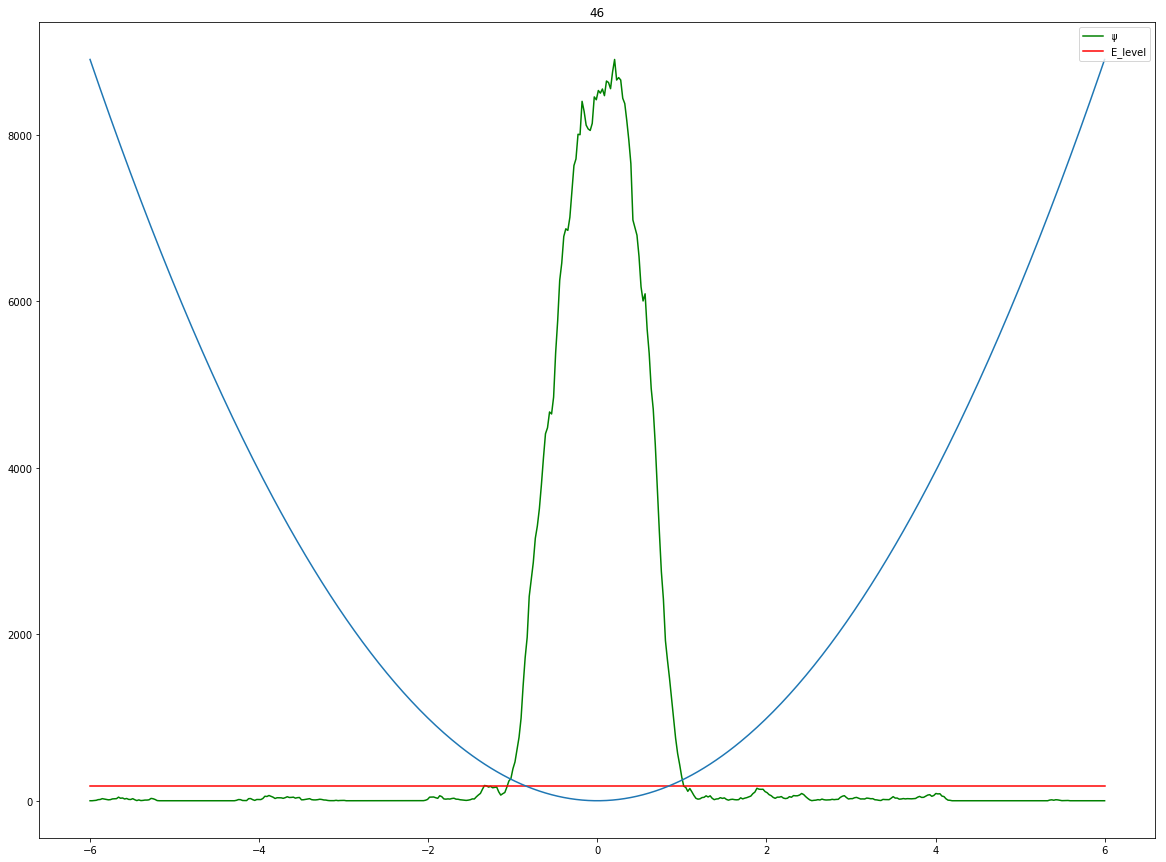

In [99]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,15)
plot_animated(gen_data())

0.52


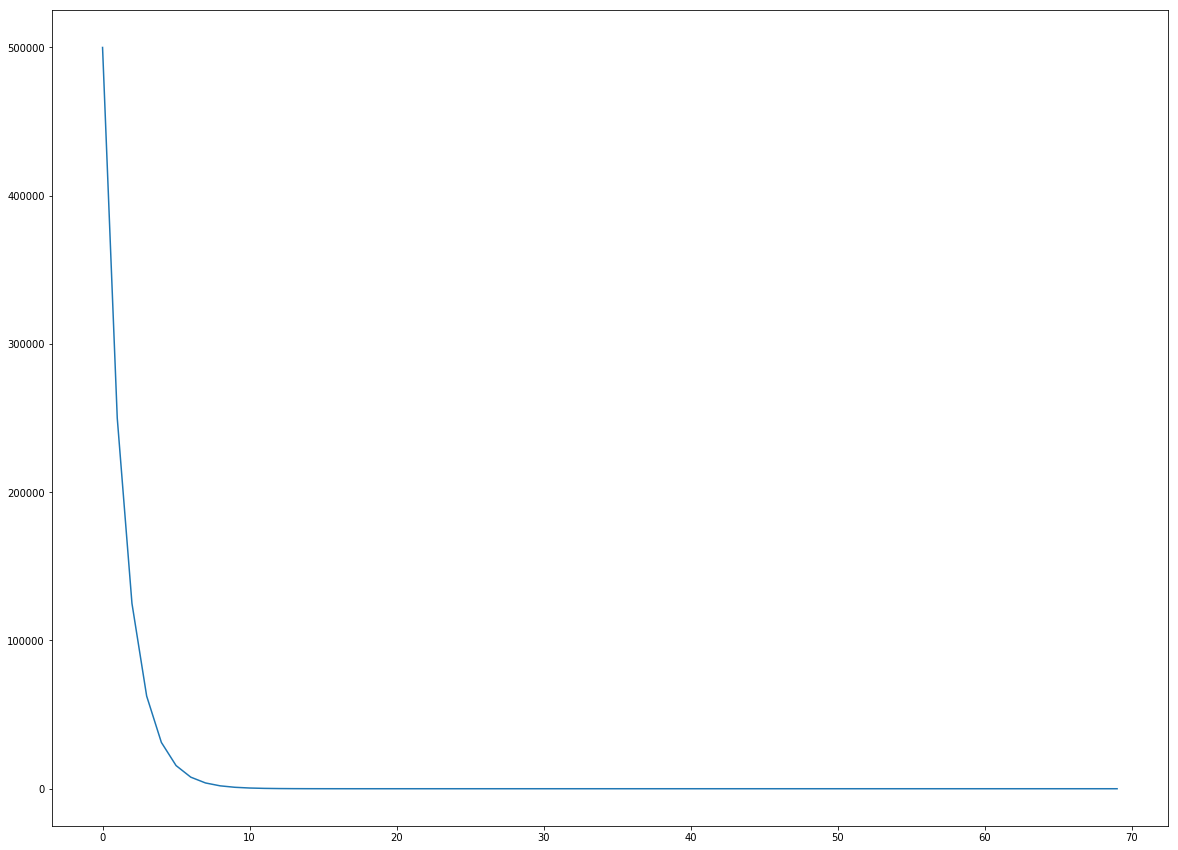

In [89]:
offset = 10
plt.plot(range(0, len(mc.E_arr)),mc.E_arr)
plt.show()